# TP4 - Grupo 14

André Lucena Ribas Ferreira - A94956

Paulo André Alegre Pinto - A97391

# Enunciado do Problema 1

![](https://paper-attachments.dropboxusercontent.com/s_9896551CC5FAD2B2EB6E4EBC08522545FA66314D29FE6A5BE8E593259F8E8A37_1672830059198_ABS.png)

![](https://paper-attachments.dropboxusercontent.com/s_C5426E33053EA04D1E3446B871CC8485C43045FF7CAAA1FC86A9B3A8E09058F9_1574702123197_Documento.png)

# Análise

O objetivo de um sistema ABS é de evitar que as rodas de um carro bloqueiem quando uma travagem brusca ocorre. Neste caso, a travagem é tal que a única força exercida no sistema é a de atrito, seja entre o corpo e as rodas como as rodas e o solo.

## Constantes
 - $a_1$ $\rightarrow$ atrito no modo `BLOCKED`;
 - $a_2$ $\rightarrow$ atrito nos restentas modos;
 - $c_1$ $\rightarrow$ constante de proporcionalidade na travagem do modo `STOPPING`;
 - $c_2$ $\rightarrow$ constante de proporcionalidade na travagem do modo `FREE`;
 - $P$ $\rightarrow$ peso do veículo em Newtons;
 - $v_i$ $\rightarrow$ velocidade inicial do veículo em metros/segundo;
 - $\tau \rightarrow$ limite máximo de tempo nos modos `FREE` e `BLOCKED`.
 
## Variáveis Contínuas
 - $T$ $\rightarrow$ tempo em segundos;
 - $V$ $\rightarrow$ velocidade do veículo em metros/segundo;
 - $R$ $\rightarrow$ velocidade das rodas em metros/segundo;
 - $Timer$ $\rightarrow$ Timer utilizado nos modos `BLOCKED` e `FREE`.
 
## Variáveis Discretas
 - $M$ $\rightarrow$ Modo de execução.

## Relações Diferenciais, por modo

### Start
 - $T = 0$, $V = v_i$ e $R = v_i$

### Free
 - $\dot{V} = -c_2(V-R)$
 - $\dot{R} = -a_2 * P + c_2(V-R)$
 
### Stopping
 - $\dot{V} = -c_1(V-R)$
 - $\dot{R} = -a_2 * P + c_1(V-R)$
 
### Blocked
 - $V = R$
 - $\dot{R} = -a_1 * P$

### Stopped
 - $V = 0$ e $R = 0$

## Switches

### Start $\rightarrow$ Free
 - Sem condição;
 - Colocar $Timer = 0$.
 
### Free $\rightarrow$ Stopping
 - $Timer \geq \tau$.
 
### Stopping $\rightarrow$ Blocked
 - 

# Implementação

Para a resolução do problema em questão, decidiu-se usar o módulo `pysmt.shortcuts`, com as funcionalidades possíveis para a utilização de um SMT Solver. Importam-se também os tipos deste Solver, a partir do módulo `pysmt.typing`.

In [13]:
from z3 import *
from pysmt.shortcuts import *
import pysmt.typing
import itertools
import matplotlib.pyplot as plt

Geram-se os valores enumerados para cada um dos Modos de execução.

In [14]:
Mode, (START, FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING', 'BLOCKED','STOPPED'))

## Gráfico, I guess

In [21]:
def simulation(a1, a2, c1, c2, dt, e, P, tau, time, vi):
    v = vi
    r = vi
    t = 0
    V = [v]
    R = [r]
    T = [t]
    timer = 0
    m = FREE
    
    while(t<time and (v>0 or r>0)):
        
        if m == STOPPING and (v - r <= e )  :
            m = BLOCKED
        
        elif timer >= tau and m == BLOCKED:
            m = FREE
            timer = 0
        
        elif timer >= tau and m == FREE:
            m = STOPPING
            timer = 0 
        
        if m == FREE:
            v, r = v + (-c2*(v-r))*dt, r + (-a2*P + c2*(v-r))*dt
        elif m == STOPPING:
            v, r = v + (-c1*(v-r))*dt, r + (-a2*P + c1*(v-r))*dt
        else:
            v, r = v + (-a1*P)*dt,     r + (-a1*P)*dt 
    
        t += dt
        timer += dt
        V.append(v)
        R.append(r)
        T.append(t)
        
    plt.plot(T,V,T,R)
    plt.title("Velocidade pelo Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Veiculo", "Rodas"], loc ="upper right")
    plt.grid(True)

In [211]:
a1 = 0.0001
a2 = 0.01 #coeficiente de atrito com uma estrada normal é de 0.7
c1 = 50
c2 = 2
dt = 0.001
e = 0.5
P = 1300 #peso médio de um carro é de 1302 kilos mas faltam aqui 9.8 m/s^2
tau = 0.2
time = 2
vi = 30

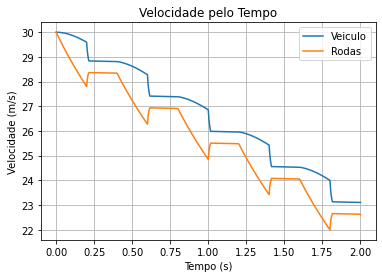

In [212]:
simulation(a1, a2, c1, c2, dt, e, P, tau, time, vi)

Qual é a ideia de ter V = v? Se eu bloquear as rodas então a velocidade dá tp? ele solavanca instantaneamente?

O "Timer" definido para o estado `BLOCKED` e `FREE` deve ser uma variável global do sistema que limita a sua operabilidade.

In [25]:
timer = 3

Declaram-se as variáveis para cada um dos estados.

In [19]:
def declare(i):
    s = {}
    s['T'] = Symbol('T'+str(i), Real)
    s['V'] = Symbol('V'+str(i), Real)
    s['R'] = Symbol('R'+str(i), Real)
    s['M'] = Symbol('M'+str(i), Mode)
    #s['c'] = Symbol('c'+str(i), Real)
    s['Timer'] = Symbol('Timer'+str(i), Real)
    return s

Define-se o predicado Inicial. Note-se a não necessidade de manipular a variável `Timer` quando esta não tem utilidade.

In [22]:
def init(s, vi):
    return And(Equals(s['T'], Real(0)), Equals(s['V'], vi), Equals(s['R'], vi), Equals(s['M'], START))

In [23]:
def untimed_trans(c, p):
    startToStopping = And(Equals(s['M'],START), Equals(p['M'],STOPPING), Equals(s['T'],p['T']), Equals(s['V'],p['V']), Equals(s['R'],p['R']))
    
    stoppingToBlocked = And(Equals(s['M'],STOPPING), Equals(p['M'],BLOCKED), Equals(s['T'],p['T']), s['V']>0, s['R']>=0, 
                            Equals(s['V'],p['V']), Equals(s['R'],p['R']), Equals(p['Timer'],0), s['V']-s['R']<e)
    
    blockedToFree = And(s['M']==BLOCKED, p['M']==FREE ,s['T']==p['T'],s['V']>0,s['R']>=0, 
                       s['V']==p['V'], s['R']==p['R'], s['Timer']>=tau, 
                       p['Timer']==0)
    
    
    freeToStopping  =  And(s['M']==FREE, p['M']==STOPPING ,s['T']==p['T'], s['V']>0,s['R']>=0, 
                          s['V']==p['V'], s['R']==p['R'], s['Timer']>=tau)
    
    
    stoppingToStopped = And(s['M']==STOPPING, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    freeToStopped = And(s['M']==FREE, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    blockedToStopped = And(s['M']==BLOCKED, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    stoppedToStopped = And(s['M']==STOPPED, p['M']==STOPPED, s['T'] == p['T'], 
                          s['V']==p['V'], s['R']== p['R'])
    
    
    Or(startToStopping, stoppingToBlocked)